# Surrogate modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

In [3]:
hi_fd = pd.read_csv('inliers_hi_FR_hi_GS_160C.csv')

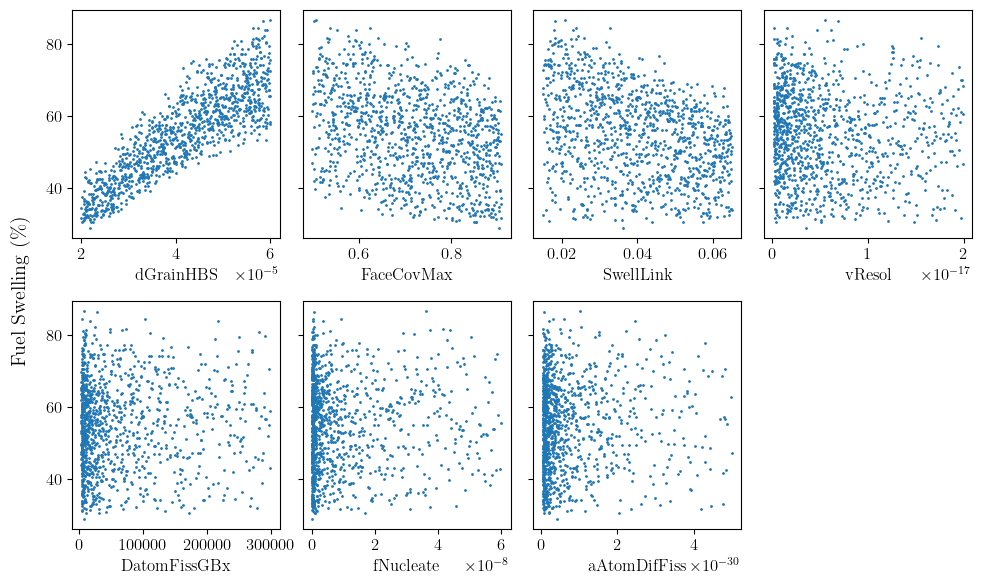

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(hi_fd.iloc[:,i], hi_fd.iloc[:,7], s=1)
    ax.set_xlabel(hi_fd.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel Swelling (\%)')
plt.tight_layout()
plt.show()

# Train/test split

In [5]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [6]:
hi_fd.iloc[:, 3] *= 1e17
hi_fd.iloc[:, 6] *= 1e30

In [7]:
xscaler = MinMaxScaler()
yscaler = RobustScaler()

In [8]:
X = xscaler.fit_transform(hi_fd.iloc[:, :-1])
y = hi_fd.iloc[:, -1].values

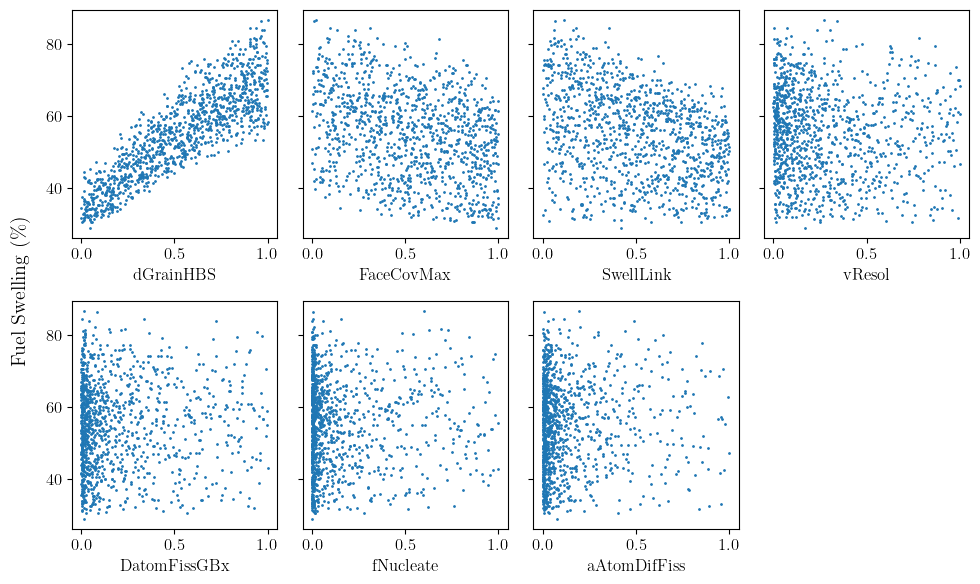

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i in range(7):
    axes[i//4, i%4].scatter(X[:,i], y, s=1)
    axes[i//4, i%4].set_xlabel(hi_fd.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel Swelling (\%)')
plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Convenience functions

In [11]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [12]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [13]:
def pred_vs_actual(mod, X_test, y_test, tt):
    y_pred = mod.predict(X_test)

    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 16})

    plt.scatter(y_test, y_pred, s=15)
    plt.plot(list(range(100)), list(range(100)),
             color='k', ls='--', label='y=x')

    plt.title(tt)
    plt.xlabel(r'Test data (swelling \%)')
    plt.ylabel(r'Surrogate pred. (swelling \%)')
    plt.legend()
    plt.show()

# Linear (OLS)

In [14]:
from sklearn import linear_model

 coeffs:  [ 37.00938376 -13.53987158 -14.51303595  -1.43414733   0.17314529
   1.18182794   1.6529917 ] 
 intercept:  49.707133929022596
 R2:  0.9535200856976818 
 RMSE:  2.596240078171161 
 MAE:  1.9745806070679266


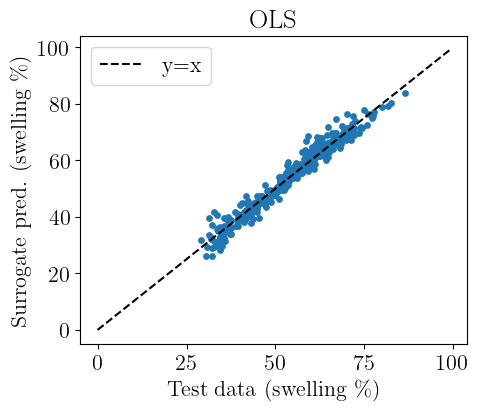

In [15]:
reg_lin = linear_model.LinearRegression().fit(X_train, y_train)

lin_coef_cept(reg_lin)
mod_metrics(reg_lin, X_test, y_test)
pred_vs_actual(reg_lin, X_test, y_test, 'OLS')

# Lasso

 coeffs:  [ 35.91455105 -12.14285583 -13.25884923  -0.           0.
   0.           0.        ] 
 intercept:  49.03492494705243
 R2:  0.9522831346767996 
 RMSE:  2.6305595843358724 
 MAE:  1.9907682763080705


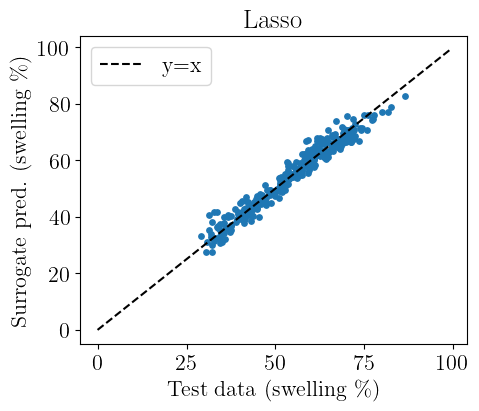

In [16]:
reg_las = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)

lin_coef_cept(reg_las)
mod_metrics(reg_las, X_test, y_test)
pred_vs_actual(reg_las, X_test, y_test, 'Lasso')

# NN

In [17]:
from sklearn.neural_network import MLPRegressor

In [18]:
reg_nn = MLPRegressor(
    hidden_layer_sizes=(50, 100, 50),
    alpha=0,
    random_state=37,
    max_iter=5000,
    tol=0.1
).fit(X_train, y_train)

 R2:  0.9526886502755754 
 RMSE:  2.6193579998190613 
 MAE:  1.9491411958813771


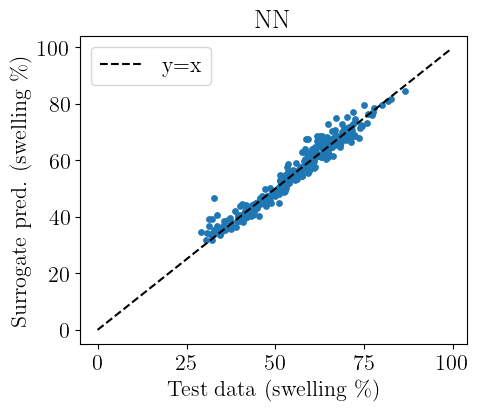

In [19]:
mod_metrics(reg_nn, X_test, y_test)
pred_vs_actual(reg_nn, X_test, y_test, 'NN')

# SVR

In [20]:
from sklearn.svm import SVR

In [21]:
reg_svr = SVR(kernel='rbf').fit(X_train, y_train)

 R2:  0.9376397466898291 
 RMSE:  3.007226403514237 
 MAE:  2.0203612050373443


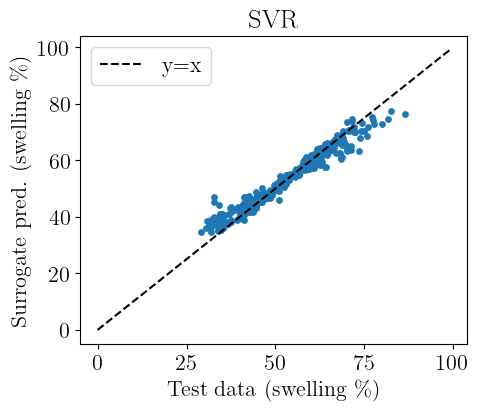

In [22]:
mod_metrics(reg_svr, X_test, y_test)
pred_vs_actual(reg_svr, X_test, y_test, 'SVR')

# Visualize prediction

In [23]:
y_pred = reg_las.predict(X_test)

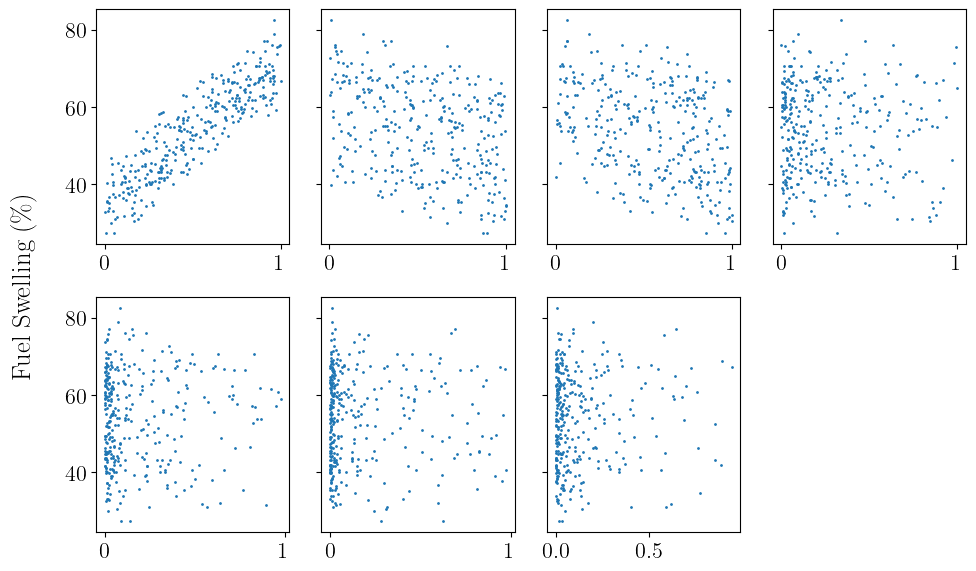

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i in range(7):
    axes[i//4,i%4].scatter(X_test[:,i], y_pred, s=1)
    #ax.set_xlabel(X_test.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel Swelling (\%)')
plt.tight_layout()
plt.show()